# Motivation
论文原文：[《Near linear time algorithm to detect community structures in large-scale networks》](https://arxiv.org/abs/0709.2938)

参考学习地址：

LPA（Label Propagation Algorithm）无需查看全局网络，内存耗费少。作为一种基于图结构的半监督学习算法，主要用于社区发现和节点分类。核心思想是：通过在网络中传播标签信息，使得相邻节点具有相似标签。相对于Louvain，Leiden等算法精度偏低。

## 执行流程
1) 初始化标签：每个节点初始拥有一个唯一标签（如节点ID），或部分节点有已知标签，其余待定
2) 标签传播迭代：每轮迭代中，每个节点根据邻居标签更新自己的标签，也即节点选择邻居中出现次数最多的标签作为自己的新标签。若图有权重，节点标签更新考虑邻居边权重
3) 终止条件：所有节点标签不在变化，或达到预设的最大迭代次数

$$
\begin{align}
l_i^{t+1} = argmax_l\sum_{j\in N(i)}w_{ij}\delta(l_j^t,l)
\end{align}
$$
其中，$l_i^{t+1}$表示节点$i$在$t+1$轮迭代时的新标签，$argmax_i$表示邻居的众数，$N(i)$为邻居的集合，$\delta$为指示函数，$w_{ij}$为边权重。

优势：
* 时间复杂度O(n)或O(nlogn)。单论迭代遍历全部节点n，每次仅计算当前节点直接邻居k，而k远小于n，时间接近O(n)。
* 无需预设参数：无需像K-means指定聚类数量
* 适合GPU并行
缺点：
* 对初始标签敏感：高度依赖初始随机标签分配，本质是算法缺乏全局目标函数引导，结果具有随机性
* 局部最优陷阱：LPA贪心策略（仅直接邻居）无法跳出局部最优，社区划分模块度显著低于全局优化算法
* 收敛性：在特定拓扑结构，LPA可能永不收敛

实例技巧：
* 内存上限50G，可以构建节点和边数量1000W+；
* 小规模数据（1W内），迭代次数为50-100，大规模，迭代次数为5-20。可能会出现
  * 过早收敛：局部最优处停止
  * 过度传播：原本独立的社区可能会被合并
    * 标签扩散：节点标签被强连接邻居拉拢
    * 震荡效应：标签在多个社区内反复传播

# 创造伪数据

In [1]:
import logging
import random
from collections import defaultdict

import numpy as np
import pandas as pd

import networkx as nx

In [2]:
# 设定节点：企业，人员，地址
# 设定边：企业-企业，企业-地址，企业-人员，人员-地址

companies = pd.DataFrame({
    "company_id": ["C01", "C02", "C03", "C04", "C05", "C06", "C07", "C08"],
    "name": ["公司A", "公司B", "公司C", "公司D", "公司E", "公司F", "公司G", "公司H"],
    "up_company_id": [None, "C01", None, "C03", None, "C05", "C06", "C07"]
})

persons = pd.DataFrame({
    "person_id": ["P01", "P02", "P03", "P04", "P05", "P06"],
    "name": ["个人a", "个人b", "个人c", "个人d", "个人e", "个人f"],
})

addresses = pd.DataFrame({
    "address_id": ["A01", "A02", "A03", "A04", "A05", "A06"],
    "address_type": ["注册地址", "办公地址", "注册地址", "办公地址", "注册地址", "办公地址"],
    "value": [
        "北京市朝阳区", "上海市浦东新区", "广州市天河区",
        "深圳市南山区", "杭州市西湖区", "成都市武侯区"
    ]
})

# 企业与人员关系（建立不同社区的连接）
ent_person_rel = pd.DataFrame({
    'company_id': ['C01', 'C01', 'C02', 'C03', 'C03', 'C04', 'C05', 'C05', 'C06', 'C07'],
    'person_id': ['P01', 'P02', 'P03', 'P01', 'P04', 'P05', 'P02', 'P06', 'P03', 'P05'],
    'relation_type': ['法定代表人', '股东', '员工', '法定代表人', '员工', '员工', '法定代表人', '员工', '员工', '员工']
})

# 企业与地址关系（建立不同社区的连接）
ent_address_rel = pd.DataFrame({
    'company_id': ['C01', 'C01', 'C02', 'C03', 'C03', 'C04', 'C05', 'C05', 'C06', 'C07'],
    'address_id': ['A01', 'A02', 'A01', 'A03', 'A04', 'A05', 'A03', 'A06', 'A04', 'A06'],
    'address_type': ['注册地址', '办公地址', '办公地址', '注册地址', '办公地址', '注册地址', '注册地址', '办公地址', '办公地址', '办公地址']
})

# 企业与企业关系（建立社区内部连接）
ent_ent_rel = pd.DataFrame({
    'from_company_id': ['C01', 'C02', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07'],
    'to_company_id': ['C02', 'C01', 'C03', 'C03', 'C03', 'C06', 'C07', 'C08'],
    'relation_type': ['投资', '合作', '投资', '投资', '投资', '投资', '投资', '投资']
})

# 人员与地址关系
per_address_rel = pd.DataFrame({
    'person_id': ['P01', 'P02', 'P03', 'P04', 'P05', 'P06'],
    'address_id': ['A01', 'A02', 'A03', 'A04', 'A05', 'A06'],
    'relation_type': ['居住地址', '居住地址', '居住地址', '居住地址', '居住地址', '居住地址']
})

In [3]:
# 构建图
# 批量添加节点
def gen_ent_nodes(enterprises):
    for row in enterprises.itertuples(index=False):
        yield (
            f"ent_{row.company_id}",
            {
                "node_type": "enterprise",
                "name": row.name,
                "up_company_id": row.up_company_id
            }
        )

def gen_per_nodes(persons):
    for row in persons.itertuples(index=False):
        yield (
            f"per_{row.person_id}",
            {
                "node_type": "person",
                "name": row.name
            }
        )

def gen_addr_nodes(addresses):
    for row in addresses.itertuples(index=False):
        yield (
            f"addr_{row.address_id}",
            {
                "node_type": "address",
                "address_type": row.address_type,
                "value": row.value
            }
        )

# 批量添加边
def gen_ent_per_edges(ent_person_rel):
    for row in ent_person_rel.itertuples(index=False):
        yield (
            f"ent_{row.company_id}",
            f"per_{row.person_id}",
            {
                "relation_type": row.relation_type
            }
        )

def gen_ent_addr_edges(ent_address_rel):
    for row in ent_address_rel.itertuples(index=False):
        yield (
            f"ent_{row.company_id}",
            f"addr_{row.address_id}",
            {
                "relation_type": row.address_type
            }
        )

def gen_ent_ent_edges(ent_ent_rel):
    for row in ent_ent_rel.itertuples(index=False):
        yield (
            f"ent_{row.from_company_id}",
            f"ent_{row.to_company_id}",
            {
                "relation_type": row.relation_type
            }
        )

def gen_per_addr_edges(per_address_rel):
    for row in per_address_rel.itertuples(index=False):
        yield (
            f"per_{row.person_id}",
            f"addr_{row.address_id}",
            {
                "relation_type": row.relation_type
            }
        )

def gen_parent_ent_edges(enterprises):
    for row in enterprises.itertuples(index=False):
        enterprise_id = f"ent_{row.company_id}"
        up_company_id = row.up_company_id
        if up_company_id and G.has_node(f"ent_{up_company_id}"):
            yield (
                f"ent_{up_company_id}",
                enterprise_id,
                {
                    "relation_type": "子母公司"
                }
            )

G = nx.Graph()
G.add_nodes_from(gen_ent_nodes(companies))
G.add_nodes_from(gen_per_nodes(persons))
G.add_nodes_from(gen_addr_nodes(addresses))
G.add_edges_from(gen_ent_per_edges(ent_person_rel))
G.add_edges_from(gen_ent_addr_edges(ent_address_rel))
G.add_edges_from(gen_ent_ent_edges(ent_ent_rel))
G.add_edges_from(gen_per_addr_edges(per_address_rel))
G.add_edges_from(gen_parent_ent_edges(companies))

# LPA社区划分

In [4]:
import sys
sys.path.append("./")

from lpa_model import LPAModel

In [5]:
lpa = LPAModel(G)

In [6]:
lpa.run()

In [7]:
lpa.get_communities()

# 重置
# lpa.reset_labels()

{'ent_C01': ['ent_C01',
  'ent_C02',
  'ent_C03',
  'per_P01',
  'per_P02',
  'per_P03',
  'per_P04',
  'addr_A01',
  'addr_A02',
  'addr_A03',
  'addr_A04'],
 'ent_C04': ['ent_C04', 'per_P05', 'addr_A05'],
 'addr_A06': ['ent_C05',
  'ent_C06',
  'ent_C07',
  'ent_C08',
  'per_P06',
  'addr_A06']}

In [8]:
lpa.analyze_communities(edge_attr='relation_type')

,community_id,node_count,edge_count,edge_types,edges,cross_community_edges,person_count,person_ids,address_count,address_ids,enterprise_count,enterprise_ids
0,addr_A06,6,7,"{'员工': 1, '子母公司': 3, '办公地址': 2, '居住地址': 1}","[(ent_C05, per_P06, 员工), (ent_C05, ent_C06, 子母...","[(ent_C05, per_P02, 法定代表人), (ent_C05, addr_A03...",1,[per_P06],1,[addr_A06],4,"[ent_C05, ent_C06, ent_C07, ent_C08]"
1,ent_C01,11,16,"{'法定代表人': 2, '股东': 1, '子母公司': 1, '员工': 2, '投资'...","[(ent_C01, per_P01, 法定代表人), (ent_C01, per_P02,...","[(ent_C03, ent_C04, 子母公司), (per_P02, ent_C05, ...",4,"[per_P01, per_P02, per_P03, per_P04]",4,"[addr_A01, addr_A02, addr_A03, addr_A04]",3,"[ent_C01, ent_C02, ent_C03]"
2,ent_C04,3,3,"{'员工': 1, '注册地址': 1, '居住地址': 1}","[(ent_C04, per_P05, 员工), (addr_A05, ent_C04, 注...","[(ent_C04, ent_C03, 子母公司), (per_P05, ent_C07, ...",1,[per_P05],1,[addr_A05],1,[ent_C04]


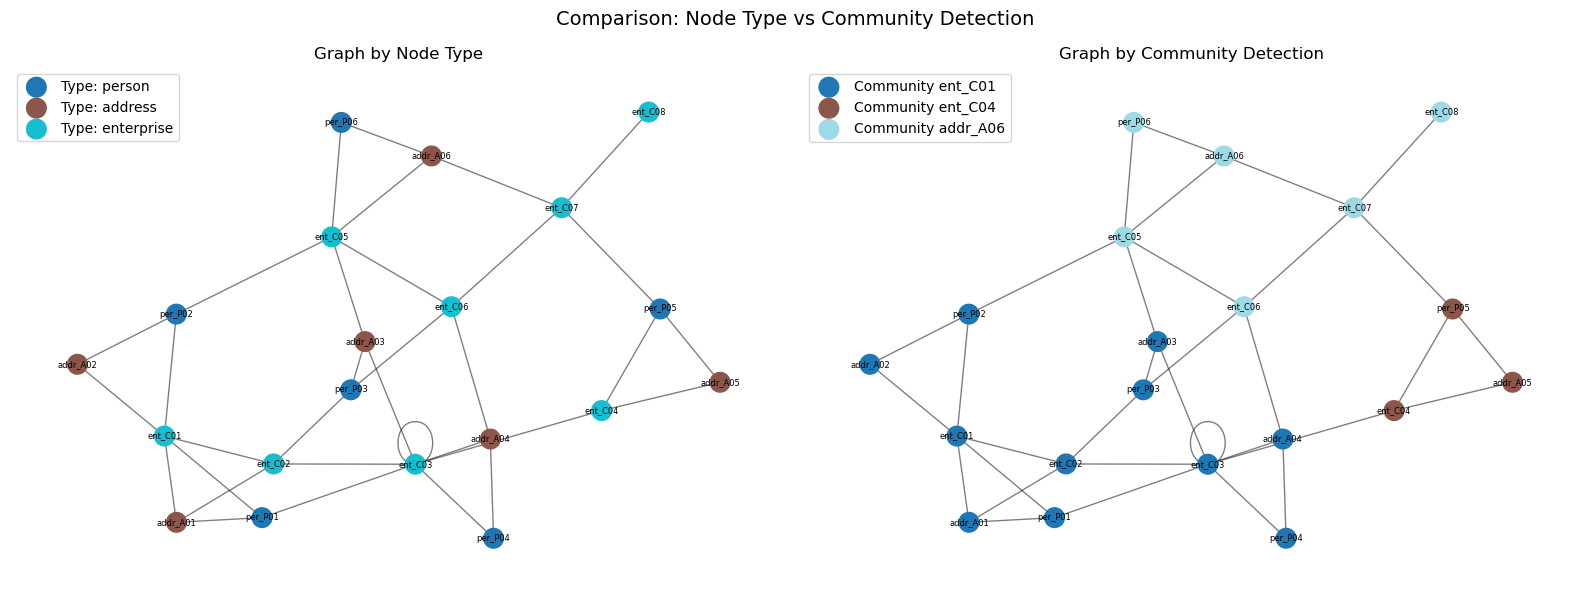

In [9]:
lpa.plot_communities()